In [24]:
# Install the here package if you haven't already
if (!requireNamespace("here", quietly = TRUE)) {
  install.packages("here")
}

library(here)
source(here("WL_helperfuncs.r"), encoding = "UTF-8")


Load winterlight data

In [25]:
# Read and preprocess speech datasets
library(readxl)
library(dplyr)
library(readr)
library(tidyr)

# Read datasets
# Read and preprocess speech data
WL <- speech_read_and_preprocess(here("WINTERLIGHT_Sunnybrook_rTMS_2023_11_03.csv"))
WL_2 <- speech_read_and_preprocess(here("WINTERLIGHT_Sunnybrook_rTMSremote_2023_11_03.csv"))

# Apply filters
WL <- WL[grep("^(TMS|MDD|MFB|OCD)", WL$participant_external_id), ]
WL_2 <- WL_2[!(WL_2$participant_external_id == "TMS039" & WL_2$session_label %in% c("V2", "V3", "V4")), ]
WL_2 <- WL_2[!(WL_2$participant_external_id == "TMS039b" & WL_2$session_label == "V1"), ]
WL_2$participant_external_id[WL_2$session_label %in% c("V2", "V3") & WL_2$participant_external_id == "TMS039b"] <- "TMS039"

# Combine datasets
WL_combined <- rbind(WL, WL_2)

# Processing participant_group
WL_combined$participant_group <- factor(
  ifelse(
    grepl("(^CTC|C_CTC)", WL_combined$participant_external_id), "Control",
    ifelse(grepl("^(TMS|MDD|MFB)", WL_combined$participant_external_id), "MDD",
    ifelse(grepl("^(OCD)", WL_combined$participant_external_id), "OCD",
    "Other" 
    )
  )
))

# Exclude specific participants
WL_combined <- WL_combined[WL_combined$participant_external_id != "CTC036" &
    WL_combined$participant_external_id != "CTC004" &
    WL_combined$participant_external_id != "CTC006" &
    WL_combined$participant_external_id != "CTC017" &
    WL_combined$participant_external_id != "CTC030" &
    WL_combined$participant_external_id != "CTC039" &
    WL_combined$participant_external_id != "CTC043" &
    WL_combined$participant_external_id != "CTC045" &
    WL_combined$participant_external_id != "CTC053" &
    WL_combined$participant_external_id != "CTC052" &
    WL_combined$participant_external_id != "CTC058" &
    WL_combined$participant_external_id != "CTC058_new" &
    WL_combined$participant_external_id != "CTC023" &
    WL_combined$participant_external_id != "CTB001", ] ## Remove participants with high QIDS

# Remove participants with baseline data post TMS 
WL_combined <- WL_combined[!(WL_combined$participant_external_id == "TMS049" & WL_combined$session_label == "V1"), ]

# Define remote participants and assign testing location
remote_participants <- c(
    "CTC001", "CTC015", "CTC021", "CTC028", "CTC013", "CTC030",
    "CTC034", "CTC036", "CTC045", "TMS038")

# Function to identify CTC046 and higher
is_ctc046_or_higher <- function(id) {
  if (grepl("^CTC", id)) {
    # Extract the numeric part of the ID and check if it is 46 or higher
    num_part <- as.numeric(sub("^CTC", "", id))
    return(num_part >= 46)
  }
  FALSE
}

# Apply the function to all participants and get those that are CTC046 or higher
ctc046_or_higher <- sapply(WL_combined$participant_external_id, is_ctc046_or_higher)
additional_ctc <- WL_combined$participant_external_id[ctc046_or_higher]


# Function to identify TMS040 and higher
is_tms040_or_higher <- function(id) {
    if (grepl("^TMS", id)) {
        # Extract the numeric part of the ID and check if it is 46 or higher
        num_part <- as.numeric(sub("^TMS", "", id))
        return(num_part >= 40)
    }
    FALSE
}

# Apply the function to all participants and get those that are CTC046 or higher
tms040_or_higher <- sapply(WL_combined$participant_external_id, is_tms040_or_higher)
additional_tms <- WL_combined$participant_external_id[tms040_or_higher]

remote_participants <- c(remote_participants, additional_ctc, additional_tms)

WL_combined$testing_location <- ifelse(WL_combined$participant_external_id %in% remote_participants, 
                                       "remote", "in-person")
WL_combined$testing_location <- ifelse(WL_combined$participant_external_id %in% c("TMS052", "TMS053"), 
                                       "remote", WL_combined$testing_location)

                                 

# Replace values in session_label column
WL_combined$session_label <- gsub("Baseline", "V1", WL_combined$session_label)

str(WL_combined)

'data.frame':	1081 obs. of  810 variables:
 $ X                                                          : int  1 2 3 4 5 6 7 8 9 10 ...
 $ sample_id                                                  : int  51341 51342 51343 51344 51345 51346 51347 51348 51349 52366 ...
 $ participant_external_id                                    : chr  "OCD108" "OCD108" "OCD108" "OCD108" ...
 $ task_name                                                  : chr  "paragraph_reading" "picture_description" "picture_description" "phonemic_fluency" ...
 $ session_label                                              : chr  "V1" "V1" "V1" "V1" ...
 $ sample_datetime_completed_utc                              : chr  "2021-12-16 17:41:38" "2021-12-16 17:42:55" "2021-12-16 17:44:07" "2021-12-16 17:45:58" ...
 $ stimulus_filename                                          : chr  "paragraph_03" "01_WinterLight_Family_in_the_kitchen_web.png" "02_WinterLight_Living_room_web.png" "en_v2_instructions_phonemic_fluency_f.m4a"

Journalling only, baseline, only MDD and controls 

In [47]:
WL_jou <-subset_by_task(WL_combined, "journaling")
WL_jou_bl <- subset_by_visit(WL_jou, "V1")
WL_jou_bl <-WL_jou_bl[WL_jou_bl$participant_group == "MDD"|WL_jou_bl$participant_group == "Control",]
str(WL_jou_bl)

'data.frame':	136 obs. of  810 variables:
 $ X                                                          : int  16 17 43 44 70 71 97 98 115 116 ...
 $ sample_id                                                  : int  52372 52373 52399 52400 52426 52427 53088 53089 53818 53819 ...
 $ participant_external_id                                    : chr  "TMS001" "TMS001" "TMS002" "TMS002" ...
 $ task_name                                                  : chr  "journaling" "journaling" "journaling" "journaling" ...
 $ session_label                                              : chr  "V1" "V1" "V1" "V1" ...
 $ sample_datetime_completed_utc                              : chr  "2022-01-04 16:09:55" "2022-01-04 16:10:17" "2022-01-04 15:55:47" "2022-01-04 15:56:21" ...
 $ stimulus_filename                                          : chr  "en_instruction_journal_feeling.mp3" "en_instruction_yesterday.mp3" "en_instruction_journal_feeling.mp3" "en_instruction_yesterday.mp3" ...
 $ terminal_state      

Remove columns with mostly or all NAs, 0 variance, and speech features irrelevant for connected speech (jitter, shimmer, hnr), or remote recording (mfccs subject to background noise)

- Set threshold to 25% for missing values 

In [57]:
WL_jou_clean <- clean_dataframe(WL_jou_bl, na_threshold = 0.25)
cols_to_remove <- grep("^(jitter|shimmer|HNR)", names(data), value = TRUE)
cols_to_remove <- c(cols_to_remove, "X", "sample_id", "task_name", "session_label", "sample_datetime_completed_utc", "terminal_state")
WL_jou_clean <- WL_jou_clean[ , !(names(WL_jou_clean) %in% cols_to_remove)]
head(WL_jou_clean)
write.csv(WL_jou_clean, "WL_jou_clean.csv", row.names = FALSE)

Columns with >= 25 % NAs: terminal_message MATTR_30 MATTR_40 MATTR_50 VERB_age_of_acquisition VERB_familiarity VERB_imageability cdr_name_address_correct_words_total cdr_name_address_correct_words_unique cdr_name_address_incorrect_words_total filled_pause_duration global_coherence_GloVe_100_avg_dist global_coherence_GloVe_100_max_dist global_coherence_GloVe_100_min_dist global_coherence_GloVe_200_avg_dist global_coherence_GloVe_200_max_dist global_coherence_GloVe_200_min_dist global_coherence_GloVe_300_avg_dist global_coherence_GloVe_300_max_dist global_coherence_GloVe_300_min_dist global_coherence_GloVe_50_avg_dist global_coherence_GloVe_50_max_dist global_coherence_GloVe_50_min_dist global_coherence_Google_300_avg_dist global_coherence_Google_300_max_dist global_coherence_Google_300_min_dist global_coherence_fastText_300_avg_dist global_coherence_fastText_300_max_dist global_coherence_fastText_300_min_dist info_units_bool_count info_units_bool_count_action info_units_bool_count_locat

,participant_external_id,stimulus_filename,tag_audio_quality,tag_background_noise,tag_participant_accent,tag_participant_clarity,tag_clinician_interference,tag_unsolicited_phi,ADJP_.._JJ,Lu_C,⋯,total_duration_audio,total_duration_speech,total_words,unfilled_pauses,zcr_kurtosis,zcr_mean,zcr_skewness,zcr_var,participant_group,testing_location
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
16,TMS001,en_instruction_journal_feeling.mp3,0,1,1,1,1,0,0.037037037,1.500000,⋯,26.54,0.35793659,0.7241379,0.20689655,13.078970,0.05549323,3.883165,0.05241373,MDD,in-person
17,TMS001,en_instruction_yesterday.mp3,1,1,1,1,1,0,0.000000000,1.500000,⋯,10.17,0.08849558,0.7727273,0.13636364,16.251423,0.04716553,4.272168,0.04494095,MDD,in-person
43,TMS002,en_instruction_journal_feeling.mp3,0,0,0,1,0,0,0.006622517,2.333333,⋯,38.29,0.94801755,1.0208333,0.04861111,9.879678,0.06753448,3.446691,0.06297357,MDD,in-person
44,TMS002,en_instruction_yesterday.mp3,1,1,0,0,0,0,0.000000000,1.100000,⋯,27.70,0.84294310,0.9354839,0.04301075,9.409625,0.06976112,3.377814,0.06489450,MDD,in-person
70,TMS003,en_instruction_journal_feeling.mp3,0,1,0,1,0,0,0.027777778,1.666667,⋯,13.31,0.50809324,0.9000000,0.13333333,10.375047,0.06533752,3.517819,0.06106853,MDD,in-person
71,TMS003,en_instruction_yesterday.mp3,0,1,0,1,0,0,0.000000000,1.000000,⋯,11.03,0.32183100,0.9285714,0.03571429,11.060361,0.06252475,3.613912,0.05861541,MDD,in-person


In [58]:
WL_jou_clean$participant_group

[1] MDD     MDD     MDD     MDD     MDD     MDD     MDD     MDD     MDD    
 [10] MDD     MDD     MDD     MDD     MDD     MDD     MDD     MDD     MDD    
 [19] MDD     MDD     MDD     MDD     MDD     MDD     MDD     MDD     MDD    
 [28] MDD     MDD     MDD     MDD     MDD     MDD     MDD     MDD     MDD    
 [37] MDD     MDD     MDD     MDD     MDD     MDD     MDD     MDD     MDD    
 [46] MDD     MDD     MDD     MDD     MDD     MDD     MDD     MDD     MDD    
 [55] MDD     MDD     MDD     MDD     MDD     MDD     MDD     MDD     MDD    
 [64] MDD     MDD     MDD     Control Control Control Control MDD     MDD    
 [73] Control Control MDD     MDD     Control Control MDD     MDD     Control
 [82] Control MDD     MDD     MDD     MDD     Control Control Control Control
 [91] Control Control Control Control MDD     MDD     MDD     MDD     MDD    
[100] MDD     Control Control MDD     MDD     MDD     MDD     MDD     MDD    
[109] MDD     MDD     Control Control Control Control MDD     MDD     MDD    
[118] MDD     Control Control MDD     MDD     Control Control MDD     MDD    
[127] Control Control MDD     MDD     Control Control MDD     MDD     MDD    
[136] MDD    
Levels: Control MDD OCD Other

In [31]:
# Identify missing values per column
missing_values_summary <- sapply(WL_jou_clean, function(x) sum(is.na(x)))
missing_values_summary <- missing_values_summary[missing_values_summary > 0]
cat("Missing values per column:\n")
print(missing_values_summary)

# Verify that the summary shows correct information
if(all(missing_values_summary == 0)) {
  cat("No missing values found in any column.\n")
} else {
  cat("Missing values found in the dataset.\n")
}

# Find rows with any missing value
rows_with_na <- apply(WL_jou_clean, 1, function(x) any(is.na(x)))

# Extract data for rows with missing values
data_with_na <- WL_jou_clean[rows_with_na, ]

# Count the number of NAs in each row of the subset
data_with_na$na_count <- rowSums(is.na(data_with_na))

# Print rows (participants) with missing values and their count of NAs
cat("Participants with missing values and their NA counts:\n")
print(data_with_na[, c("participant_external_id", "na_count")])


Missing values per column:
                       VERB_frequency                VERB_sentiment_arousal 
                                    3                                     3 
             VERB_sentiment_dominance                VERB_sentiment_valence 
                                    3                                     3 
                         ave_cos_dist                             graph_asp 
                                    4                                     2 
               graph_avg_total_degree             graph_diameter_undirected 
                                    2                                     2 
                            graph_lcc                             graph_lsc 
                                    2                                     2 
                      graph_num_edges                   graph_pe_undirected 
                                    2                                     2 
   local_coherence_GloVe_100_avg_dist    local_co

Participants with missing values and their NA counts:
     participant_external_id na_count
115                   TMS005       14
340                   TMS016       19
376                   TMS020        7
394                   TMS019        1
657                   OCD116       21
5610                  TMS030       14
2381                  CTC034       19
5451                  CTC059       19


MICE Imputation

-Imputes missing data with plausible data values which are drawn from a distribution specifically designed for each missing data point 
-Performs several iterations (usually max 5) of predictive models in which each missing variable is imputed using the other variables 
-For each imputed data set, an analysis is performed and then then results of these multiple analyses are pooled together

In [54]:
# Replace positive infinity values with NA
WL_jou_clean[WL_jou_clean == Inf] <- NA

# Replace negative infinity values with NA
WL_jou_clean[WL_jou_clean == -Inf] <- NA

head(WL_jou_clean)

,participant_external_id,stimulus_filename,tag_audio_quality,tag_background_noise,tag_participant_accent,tag_participant_clarity,tag_clinician_interference,tag_unsolicited_phi,ADJP_.._JJ,Lu_C,⋯,total_duration_audio,total_duration_speech,total_words,unfilled_pauses,zcr_kurtosis,zcr_mean,zcr_skewness,zcr_var,participant_group,testing_location
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
16,TMS001,en_instruction_journal_feeling.mp3,0,1,1,1,1,0,0.037037037,1.500000,⋯,26.54,0.35793659,0.7241379,0.20689655,13.078970,0.05549323,3.883165,0.05241373,MDD,in-person
17,TMS001,en_instruction_yesterday.mp3,1,1,1,1,1,0,0.000000000,1.500000,⋯,10.17,0.08849558,0.7727273,0.13636364,16.251423,0.04716553,4.272168,0.04494095,MDD,in-person
43,TMS002,en_instruction_journal_feeling.mp3,0,0,0,1,0,0,0.006622517,2.333333,⋯,38.29,0.94801755,1.0208333,0.04861111,9.879678,0.06753448,3.446691,0.06297357,MDD,in-person
44,TMS002,en_instruction_yesterday.mp3,1,1,0,0,0,0,0.000000000,1.100000,⋯,27.70,0.84294310,0.9354839,0.04301075,9.409625,0.06976112,3.377814,0.06489450,MDD,in-person
70,TMS003,en_instruction_journal_feeling.mp3,0,1,0,1,0,0,0.027777778,1.666667,⋯,13.31,0.50809324,0.9000000,0.13333333,10.375047,0.06533752,3.517819,0.06106853,MDD,in-person
71,TMS003,en_instruction_yesterday.mp3,0,1,0,1,0,0,0.000000000,1.000000,⋯,11.03,0.32183100,0.9285714,0.03571429,11.060361,0.06252475,3.613912,0.05861541,MDD,in-person


,participant_external_id,stimulus_filename,tag_audio_quality,tag_background_noise,tag_participant_accent,tag_participant_clarity,tag_clinician_interference,tag_unsolicited_phi,ADJP_.._JJ,Lu_C,⋯,temporal_cohesion_avg_switches_in_tense,NOUN_sentiment_arousal,NOUN_sentiment_dominance,NOUN_sentiment_valence,sub_coord_ratio,MATTR_20,NOUN_age_of_acquisition,NOUN_familiarity,NOUN_imageability,
106,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,0
6,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,0,0,0,3
5,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,0,1,1,1,1
10,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,0,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,0,0,1,1,1,2
2,1,1,1,1,1,1,1,1,1,1,⋯,0,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,⋯,0,1,1,1,1,1,0,0,0,4
1,1,1,1,1,1,1,1,1,1,1,⋯,0,1,1,1,0,0,0,0,0,6
1,1,1,1,1,1,1,1,1,1,1,⋯,0,0,0,0,0,0,0,0,0,9
2,1,1,1,1,1,1,1,1,1,1,⋯,1,0,0,0,1,0,0,0,0,8


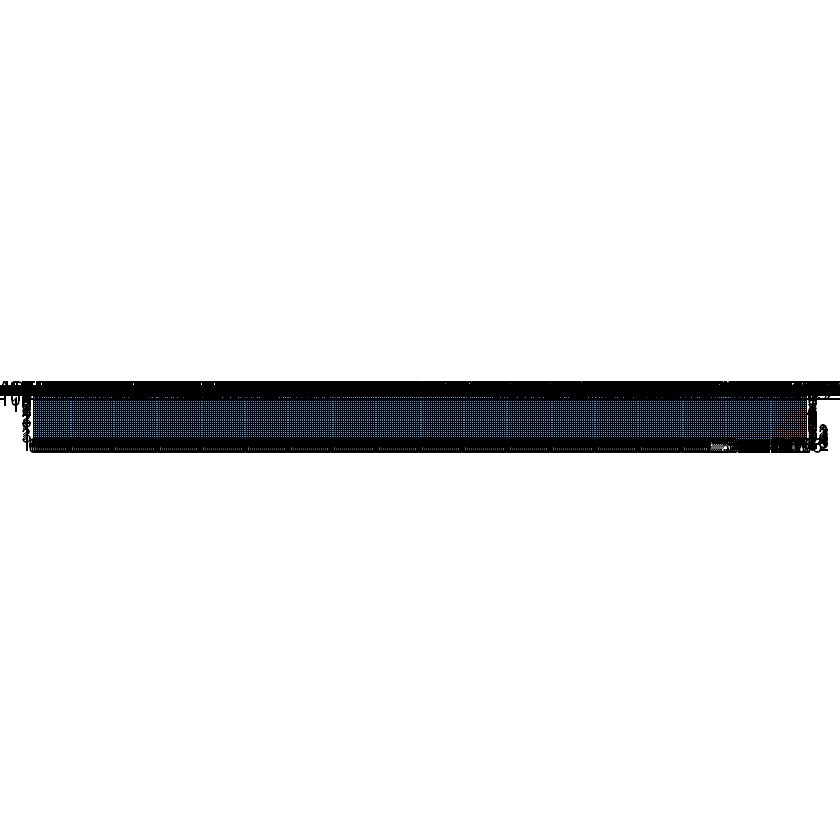

In [34]:
library(mice)
md.pattern(WL_jou_clean)

Random forest baseline, all task files, no feature selection 

In [67]:
library(caret)
library(randomForest)
library(RANN)
library(pROC)

# Set a seed for reproducibility
set.seed(123)

# Ensure the target variable is a factor and drop levels with no data
WL_jou_clean$participant_group <- factor(WL_jou_clean$participant_group)
WL_jou_clean$participant_group <- droplevels(WL_jou_clean$participant_group)

# Replace Inf values with NA for imputation in numeric columns
WL_jou_clean <- data.frame(lapply(WL_jou_clean, function(x) {
  if(is.numeric(x)) { x[is.infinite(x)] <- NA }
  return(x)
}))

# Preprocess data: center, scale, and impute missing values
preProcModel <- preProcess(WL_jou_clean, method = c("center", "scale", "knnImpute"))
WL_jou_clean_preprocessed <- predict(preProcModel, WL_jou_clean)

# Split the preprocessed dataset into training and testing sets
trainIndex <- createDataPartition(WL_jou_clean_preprocessed$participant_group, p = 0.7, list = FALSE)
trainData <- WL_jou_clean_preprocessed[trainIndex, ]
testData <- WL_jou_clean_preprocessed[-trainIndex, ]

# Remove 'participant_external_id' column if it exists
trainData <- trainData[, !names(trainData) %in% c("participant_external_id")]
testData <- testData[, !names(testData) %in% c("participant_external_id")]

# Train the model with Random Forest
fitControl <- trainControl(method = "repeatedcv", number = 10, repeats = 5, classProbs = TRUE, summaryFunction = twoClassSummary)
rfFit <- train(participant_group ~ ., data = trainData, method = "rf", trControl = fitControl, ntree = 500, metric = "ROC")

# Predict on the testing set with class probabilities
predictions <- predict(rfFit, newdata = testData, type="prob")

# Calculate AUC for the positive class 'MDD'
rocResponse <- roc(response = as.numeric(testData$participant_group) - 1, predictor = predictions$MDD)
aucValue <- auc(rocResponse)
print(paste("AUC:", aucValue))

# Convert binary predictions and the test data's participant_group to factors with the same levels
binaryPredictions <- factor(binaryPredictions, levels = c("Control", "MDD"))
testData$participant_group <- factor(testData$participant_group, levels = c("Control", "MDD"))

# Generate and print confusion matrix
confMatrix <- confusionMatrix(binaryPredictions, testData$participant_group)
print(confMatrix)



Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC: 0.772401433691756"
Confusion Matrix and Statistics

          Reference
Prediction Control MDD
   Control       5   1
   MDD           4  30
                                         
               Accuracy : 0.875          
                 95% CI : (0.732, 0.9581)
    No Information Rate : 0.775          
    P-Value [Acc > NIR] : 0.08685        
                                         
                  Kappa : 0.5935         
                                         
 Mcnemar's Test P-Value : 0.37109        
                                         
            Sensitivity : 0.5556         
            Specificity : 0.9677         
         Pos Pred Value : 0.8333         
         Neg Pred Value : 0.8824         
             Prevalence : 0.2250         
         Detection Rate : 0.1250         
   Detection Prevalence : 0.1500         
      Balanced Accuracy : 0.7616         
                                         
       'Positive' Class : Control        
         

Random forest baseline, "feeling file", no feature selection

In [74]:
library(caret)
library(randomForest)
library(RANN)
library(pROC)

# Set a seed for reproducibility
set.seed(123)

#only feeling
WL_jou_feeling <- WL_jou_clean[WL_jou_clean$stimulus_filename == "en_instruction_journal_feeling.mp3",]


# Ensure the target variable is a factor and drop levels with no data
WL_jou_feeling$participant_group <- factor(WL_jou_feeling$participant_group)
WL_jou_feeling$participant_group <- droplevels(WL_jou_feeling$participant_group)

# Replace Inf values with NA for imputation in numeric columns
WL_jou_feeling <- data.frame(lapply(WL_jou_feeling, function(x) {
  if(is.numeric(x)) { x[is.infinite(x)] <- NA }
  return(x)
}))

# Preprocess data: center, scale, and impute missing values
preProcModel <- preProcess(WL_jou_feeling, method = c("center", "scale", "knnImpute"))
WL_jou_clean_preprocessed <- predict(preProcModel, WL_jou_feeling)

# Split the preprocessed dataset into training and testing sets
trainIndex <- createDataPartition(WL_jou_clean_preprocessed$participant_group, p = 0.7, list = FALSE)
trainData <- WL_jou_clean_preprocessed[trainIndex, ]
testData <- WL_jou_clean_preprocessed[-trainIndex, ]


# Remove 'participant_external_id' column if it exists
trainData <- trainData[, !names(trainData) %in% c("participant_external_id")]
testData <- testData[, !names(testData) %in% c("participant_external_id")]


# Train the model with Random Forest
fitControl <- trainControl(method = "repeatedcv", number = 10, repeats = 5, classProbs = TRUE, summaryFunction = twoClassSummary)
rfFit <- train(participant_group ~ ., data = trainData, method = "rf", trControl = fitControl, ntree = 500, metric = "ROC")

# Predict on the testing set with class probabilities
predictions <- predict(rfFit, newdata = testData, type="prob")

# Calculate AUC for the positive class 'MDD'
rocResponse <- roc(response = as.numeric(testData$participant_group) - 1, predictor = predictions$MDD)
aucValue <- auc(rocResponse)
print(paste("AUC:", aucValue))

# Convert binary predictions and the test data's participant_group to factors with the same levels
binaryPredictions <- factor(binaryPredictions, levels = c("Control", "MDD"))
testData$participant_group <- factor(testData$participant_group, levels = c("Control", "MDD"))

# Generate and print confusion matrix
confMatrix <- confusionMatrix(binaryPredictions, testData$participant_group)
print(confMatrix)


Warning message in preProcess.default(WL_jou_feeling, method = c("center", "scale", :
"These variables have zero variances: tag_unsolicited_phi"


[1] "All categorical variables have at least 2 levels."


ERROR: Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]): contrasts can be applied only to factors with 2 or more levels
